# LAB : Advanced Smart Sensing - Matrix completion - **Cellitti & Negroni**

> The LAB aims at implementing and test the algorithms which enable **rank minimization** of a matrix in the context of **matrix completion**.

> We were given a dataset with in each row a user id, a movie id and a rating given by that user to that movie (here we do not consider the fourth column i.e. "timestamp"). Our goal is to complete the sparse **`movies × users`** matrix as best we can with three different algorithms: **`SVP, SVT and ADMiRA`**.


# 1. Dataset

> Import the necessary libraries:

In [ ]:
import pandas as pd
import requests
from zipfile import ZipFile
import os
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

> Download the MovieLens dataset directly from the link provided:

In [ ]:
# URL of the MovieLens dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
download_dir = './movielens_data'

# Create the directory if it does not exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Download the dataset
zip_file_path = os.path.join(download_dir, 'ml-latest-small.zip')
response = requests.get(url)

# Save the downloaded zip file
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Extract the contents of the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(download_dir)

# Path to the ratings.csv file
ratings_csv_path = os.path.join(download_dir, 'ml-latest-small', 'ratings.csv')

# Load the dataset into a DataFrame
data = pd.read_csv(ratings_csv_path)

# Dimensions of the DataFrame
print("Dimensions of the DataFrame:", data.shape)

# Show the data
data

Dimensions of the DataFrame: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


> Let's show some additional informations about the dataset:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


> Performing some preliminary analysis on the data, we realised that although the value of unique values in the movies column was **9724** (thus the number of movies in our dataset), their ids reached a much larger number, namely **193609**. Creating the sparse matrix in this way would have resulted in rows of all zeros, as a film not in the dataset could not be voted on by any user. To create a sparse matrix consistent with our data, we decided to **re-index the movies column** so that the smallest id would have a value of 1 and the largest id would have a value equal to the total number of unique elements in the column.

In [ ]:
# Let's recode the indexes of the movies in order to build our matrix

# Sort unique indices
sorted_indices = np.unique(data['movieId'])

# Create a new mapping
new_mapping = {sorted_indices[i]: i for i in range(len(sorted_indices))}

# Apply the new mapping to the array indices in a new variable in the data
data['movieIdR'] = ([new_mapping[index] for index in data['movieId']])
data['userId'] = data['userId'] - 1

> To handle the **movies × users plain matrix** consisting of a huge amount of zeros, we are going to use a sparse matrix representations thanks to the function **coo_matrix**:

In [ ]:
# Create a sparse matrix representation
sparse_matrix = coo_matrix((data['rating'], (data['movieIdR'], data['userId'])))

In [ ]:
sparse_matrix.toarray().shape

(9724, 610)

It's the right shape.

In [ ]:
# Save the number of rows and columns the matrix for later
p = sparse_matrix.shape[0]
q = sparse_matrix.shape[1]

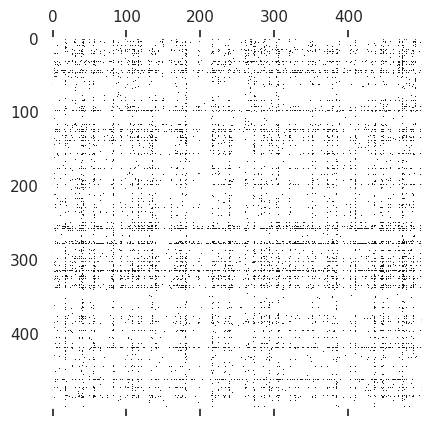

In [ ]:
# We use for visualization purpose just a part of the matrix (first 500x500)
plt.spy(sparse_matrix.toarray()[:500,:500]);

# 2. Minimal rank choice of a matrix

1. In order to choose the rank desired for the following algorithms, our way to proceed is based firstly on searching that value using the **Elbow's rule**. In this way the value choosen should be selected from the decreasing plot of the singular values, where the decrease of it become significantly smaller.

2. Secondly, we perform an empirical selection rule based on the the **difference between two sequential singular values** and an iterative threshold that is updated at each step.

### 2.1 Graphical analysis

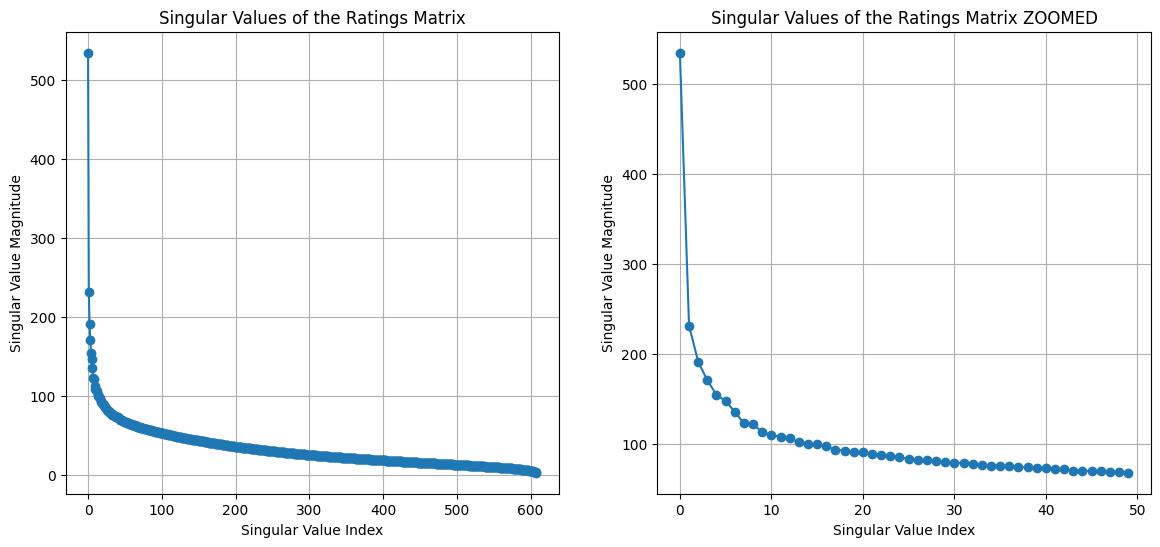

In [ ]:
# Perform Singular Value Decomposition
U, sigma, Vt = svds(sparse_matrix, k=min(sparse_matrix.shape)-1)

# Reverse the singular values array to plot them in descending order
sigma = np.flip(sigma)

# Plot the singular values
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
plt.plot(sigma, marker='o')
plt.title('Singular Values of the Ratings Matrix')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.grid(True)

# Plot the singular values ZOOMED
#plt.figure(figsize = (14,6))
plt.subplot(1,2,2)
plt.plot(sigma[:50], marker='o')
plt.title('Singular Values of the Ratings Matrix ZOOMED')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.grid(True)
plt.show()

The first plot shows the singular values of the matrix in decreasing order. As we said before, we can notice that there is an elbow between 0 and 50, where the initial significant drop seem to become smoother. Hence, we provided also the zoomed plot of the first 50 singular values where it is possible to see the elbow between about 5 and 15.

That could represent an initial guess of the rank of the sparse matrix,increasing the number of singular values considered beyond this range may not contibute strongly in capturing the real structure of the data.

 ### 2.2 Empirical analysis

Empirically determined rank: 7


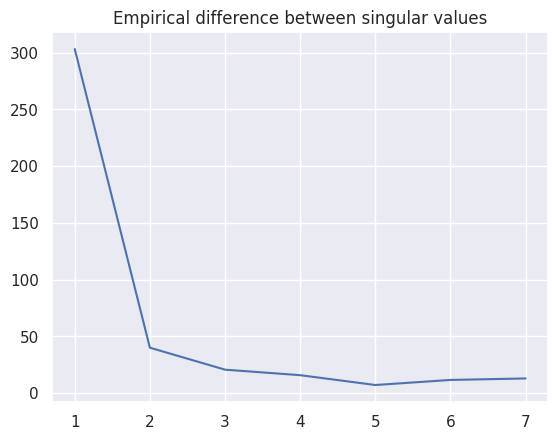

In [ ]:
# Determine the rank empirically

threshold = [0]  # Adjust as needed
rank = 0

for i in range(1,len(sigma)):
    if (sigma[i-1] - sigma[i]) < 0.1*threshold[-1]:
        rank = i - 1
        break
    threshold.append(sigma[i - 1] - sigma[i])
print("Empirically determined rank:", rank)

sns.set_theme()
sns.lineplot(x=range(1,len(threshold)),y = threshold[1:]).set_title("Empirical difference between singular values");

As we expected from the graphical analysis, the rank r of the sparse matrix considered falls in the interval 5-15, precisely according to our empirical analysis it is **7**.

# 3. Implementation and application

> Let's sort the dataset first on the movie and then on the user:

In [ ]:
sorted_data = data.sort_values(by=['movieIdR', 'userId'])

> Create the **y variable** that is the rating scores:

In [ ]:
y = np.array(sorted_data['rating'])

## 3.1 Singular Value Projection algorithm

> Find the indices of the partial observations to use later on:

In [ ]:
from scipy.sparse import find
# Find non-zero values and their corresponding indices
row_indices, col_indices, _ = find(sparse_matrix)

In [ ]:
row_indices, col_indices

(array([   0,    0,    0, ..., 9721, 9722, 9723], dtype=int32),
 array([  0,   4,   6, ..., 183, 183, 330], dtype=int32))

> Let's define the **$M$ matrix**:

In [ ]:
def M(matrix, row_indices, col_indices):
    """
    Measurement operator M: Converts a sparse matrix to a vector by stacking initial non-zero values in order.

    Parameters:
    - matrix (numpy.ndarray or scipy.sparse.coo_matrix): Input matrix of size p x q.
    - row_indices (numpy.ndarray): Row indices of initial non-zero values.
    - col_indices (numpy.ndarray): Column indices of initial non-zero values.

    Returns:
    - numpy.ndarray: Output vector of size n x 1 containing non-zero values in order.
    """
    if not isinstance(matrix, (np.ndarray, np.matrix, coo_matrix)):
        raise ValueError("Input matrix must be a NumPy array or a scipy.sparse.coo_matrix.")
    if isinstance(matrix, (np.ndarray)):
      out = matrix
    else:
      out = matrix.toarray()

    # Find the initial partial-observation values at specified indices
    output_vector = out[row_indices, col_indices]

    return output_vector

> Let's check that the function works properly:

In [ ]:
np.all(M(sparse_matrix, row_indices, col_indices) == y)

True

> Let's define the **$M^*$ matrix**:

In [ ]:
def M_star(output_vector, row_indices, col_indices):
    """
    Inverse Measurement Operator: Reconstructs a matrix from a vector.

    Parameters:
    - output_vector (numpy.ndarray): Input vector of size n x 1 containing non-zero values in order.
    - row_indices (numpy.ndarray): Row indices of initial non-zero values.
    - col_indices (numpy.ndarray): Column indices of initial non-zero values.

    Returns:
    - numpy.ndarray or scipy.sparse.coo_matrix: Reconstructed matrix of size p x q.
    """

    # Create a COO matrix with the values in the same position as the original sparse matrix
    reconstructed_matrix = coo_matrix((output_vector, (row_indices, col_indices)))

    return reconstructed_matrix

> Let's check that the function works properly:

In [ ]:
np.all(M_star(M(sparse_matrix, row_indices, col_indices), row_indices, col_indices).toarray() == sparse_matrix.toarray())

True

> Before applying the algorithm let's define some function that will be useful for us

In [ ]:
def hard_thresholding(sigma, r, p, q):
    matrix_sigma = (np.zeros([p,q]))
    sigma = np.concatenate((sigma[:r],np.zeros(len(sigma)-r)))
    np.fill_diagonal(matrix_sigma, sigma)
    return matrix_sigma

def RMSE(y, yhat):
    # square norm
    return math.sqrt(sum((y-yhat)**2)/len(y))

> **`Remark`** : we have noticed that there is a *svds* function from scipy.sparse.linalg that computes the partial singular value decomposition of a sparse matrix. As can be seen from the official documentation, however, it "computes the largest or smallest k singular values and corresponding singular vectors of a sparse matrix A. The order in which the singular values are returned is not guaranteed.". This might be fine for the SVP algorithm (since you have to do hard thresholding of the first r singular values), but not for the SVT! \\
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

$$
\underset{pxr}U \; \underset{rxr}\Sigma \; \underset{rxq}V^T
$$

 > So, since the purpose of this LAB is to create the SVP function ourselves and that wouldn't be the correct way to build SVT let's use the common *svd* function (from numpy.linalg) which decomposes a matrix X as $U \Sigma V^T$ and then create the functions to do the hard thresholding and soft-thresholding ourselves. \\
 Notice: full_matrices = True. \\
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

> In the ADMiRA algorithm we will use svds specifying the number of singular values we need, since it turned out to be faster.


> Now, it's time to code the **algorithm for SVP**:

In [ ]:
def SVP(y, r, p, q, step_size):

    '''
    y is a vector of the total number of observations
    M is the operator that we are going to use
    r is the expected rank computed empirically before
    p is the number of rows of the matrix
    q is the number of columns of the matrix
    '''

    epsilon = 0.01
    cardin = len(y)
    RMSEs = [0, RMSE(y,np.zeros(len(y)))]
    X_new = (np.zeros([p,q]))
    i = 1
    while abs(RMSEs[-1] - RMSEs[-2]) > epsilon: # until stopping criteria occurred

        # Let's define a Landweber iteration, using a gradient step in order to find the best approximation
        # replace it by decreasing the error y - M(X_n) at each step
        X_half = np.array(X_new + step_size*M_star(y - M(X_new, row_indices, col_indices), row_indices, col_indices))

        if isinstance(X_half, np.ndarray):
            U, sigma, Vt = np.linalg.svd(X_half)
        else:
            U, sigma, Vt = np.linalg.svd(X_half.toarray())


        # Using the hard thresholding operator rebuild a matrix with the expected rank r that we want to obtain
        X_new = np.dot(U, np.dot(hard_thresholding(sigma,r,len(U), len(Vt)),Vt))

        RMSEs.append(RMSE(y,M(X_new,row_indices, col_indices)))
        i+=1
        print(RMSEs[-1])

    return X_new, RMSEs

> Let's apply it keeping track of the time needed:

In [ ]:
start = time.time()
X_SVP, RMSEs_SVP = SVP(y, rank, sparse_matrix.shape[0], sparse_matrix.shape[1], .5)
end = time.time()

> Let's see the **results**:

In [ ]:
print("RMSE obtained with SVP is:", RMSEs_SVP[-1])
print("Time needed for SVP:", end - start)
print("Number of iterations needed for SVP:", len(RMSEs_SVP))

RMSE obtained with SVP is: 1.1522147396997064
Time needed for SVP: 1178.63552069664
Number of iterations needed for SVP: 42


> Let's visualize the evolution of RMSE:

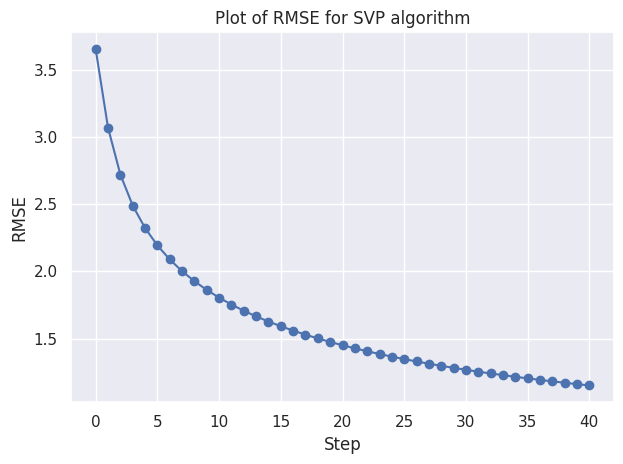

In [ ]:
plt.plot(RMSEs_SVP[1:], marker = 'o');
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.title('Plot of RMSE for SVP algorithm')

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2 Convex relaxation algorithm

> **Singular Value Thresholding**

Now our focus is try to understand the behaviour of the SVT tecnhique. The algorithm to implement is similar to the SVP that is implemented before, where the only change is based on the Hard Thresholding matrix, subsituted by the following equation (Soft Thresholding):

$$
S_{λ}(x) = sign(x)(|x| - λ)_+
$$

Before going on with the algorithm, is time to define our function outside

In [ ]:
def soft_thresholding(x, lam, p, q):
    """
    Parameters:
    - x: Input array
    - lam: Threshold parameter
    Returns:
    - Thresholded array
    """
    new_sigma = np.zeros([p,q])

    # Apply the soft thresholding for each element in the diagonal
    diagonal = np.sign(x) * np.maximum(np.abs(x) - lam, 0)

    # Rebuild the modified singular values matrix
    np.fill_diagonal(new_sigma, diagonal)
    return new_sigma

In [ ]:
def SVT(y, lam, p, q, step_size):

    """
    - y is a vector of the total number of observations
    - M is the operator that we are going to use
    - r is the expected rank computed empirically before
    - p is the number of rows of the matrix
    - q is the number of columns of the matrix
    - step_size is like the learning rate in the gradient descent
    """

    epsilon = 0.01
    cardin = len(y)
    RMSEs = [0, RMSE(y,np.zeros(len(y)))]
    X_new = (np.zeros([p,q]))
    i = 1
    while abs(RMSEs[-1] - RMSEs[-2]) > epsilon:

        #Let's define a Landweber iteration, using a gradient step in order to find the best approximation
        # replace it by decreasing the error y - M(X_n) at each step
        X_half = np.array(X_new + step_size*M_star(y - M(X_new, row_indices, col_indices), row_indices, col_indices))
        if isinstance(X_half, np.ndarray):
            U, sigma, Vt = np.linalg.svd(X_half)
        else:
            U, sigma, Vt = np.linalg.svd(X_half.toarray())

        # Using the hard thresholding operator rebuild a matrix with the expected rank that we want to obtain
        X_new = np.dot(U, np.dot(soft_thresholding(sigma,lam,len(U), len(Vt)),Vt))

        RMSEs.append(RMSE(y,M(X_new, row_indices, col_indices)))
        i+=1

    return X_new, RMSEs

In [ ]:
def cross_validate_lambda(y, lam_values, p, q, step_size):

    """
    - y is a vector of the total number of observations
    - lam_values is the grid of possible values
    - p is the number of rows of the matrix
    - q is the number of columns of the matrix
    - step_size is like the learning rate in the gradient descent
    """

    ranks = []
    RMSE_lam_l = []

    for lam in tqdm(range(len(lam_values)), unit="iteration"):

        # Compute for each lambda the correspondent SVT and save the values of RMSE and the final matrix X_new
        X_new, RMSE_lam = SVT(y, lam_values[lam], p, q, step_size)

        RMSE_lam_l.append(RMSE_lam[-1])

        # Compute the rank of the matrix
        rank_X_new = np.linalg.matrix_rank(X_new)
        ranks.append(rank_X_new)

    return ranks, RMSE_lam_l

# Let's try an implementation of the cross validation
lam_values = [0.5,1,2,5,10,15,20,25,30]  # Lambda values to be tested

ranks_SVT, RMSE_CV_SVT = cross_validate_lambda(y, lam_values, p, q, .5)

100%|██████████| 9/9 [1:06:34<00:00, 443.78s/iteration]


> Let's plot the results of CV:

Text(0.5, 0.98, 'Results of Cross Validation for SVT')

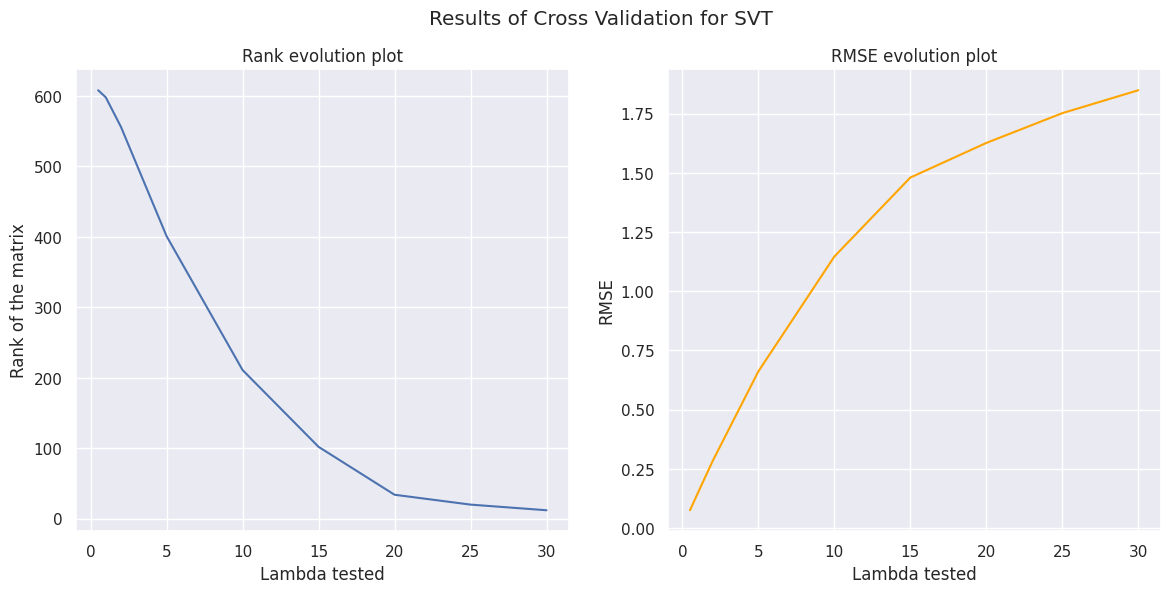

In [ ]:
plt.figure(figsize =(14,6))

# First subplot
plt.subplot(1,2,1)
sns.set_theme()
sns.lineplot(x=lam_values,y = ranks_SVT).set_title('Rank evolution plot')
plt.xlabel('Lambda tested')
plt.ylabel('Rank of the matrix')

# Second subplot
plt.subplot(1,2,2)
sns.set_theme()
sns.lineplot(x=lam_values,y = RMSE_CV_SVT, color ='orange').set_title('RMSE evolution plot')
plt.xlabel('Lambda tested')
plt.ylabel('RMSE')
plt.suptitle('Results of Cross Validation for SVT')

Here it's possible to notice that if we made our decision only relying on the RMSE we would end up choosing a lambda very low, that correspond to a very high rank of the matrix. Since the goal should be to complete the matrix we select the value of lambda = 20 that seems a good trade-off between minimizing the rank and not increasing too much the error (since we noticed an elbow in the curve of the evolution of the rank). In fact, it could be expected that if one decrease the rank of a matrix, since it's an estimate of the original matrix, the RMSE will increase.

> Let's apply it keeping track of the time needed:

In [ ]:
start = time.time()
X_SVT, RMSEs_SVT = SVT(y, 20, sparse_matrix.shape[0], sparse_matrix.shape[1], .5)
end = time.time()

> Let's see the **results**:

In [ ]:
print("RMSE obtained with SVT is:", RMSEs_SVT[-1])
print("Time needed for SVT:", end - start)
print("Number of iterations needed for SVT:", len(RMSEs_SVT))

RMSE obtained with SVT is: 1.6259376780962607
Time needed for SVT: 594.0332217216492
Number of iterations needed for SVT: 23


> Let's visualize the evolution of RMSE:

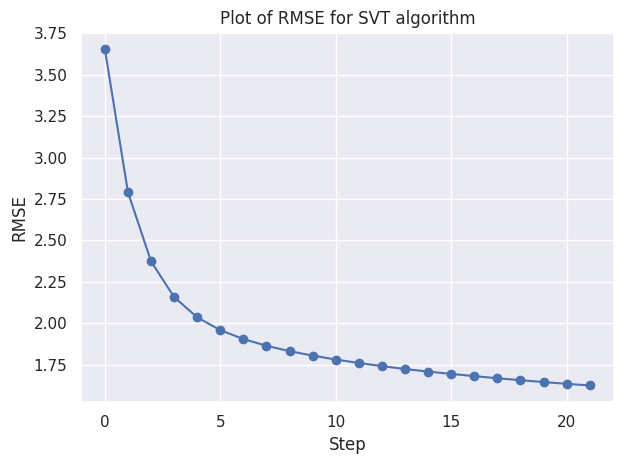

In [ ]:
plt.plot(RMSEs_SVT[1:], marker = 'o');
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.title('Plot of RMSE for SVT algorithm')

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.3 ADMiRA algorithm

> "Atomic Decomposition for Minimum Rank Approximation". \\
It is used a selection rule to generalize the correlation maximization in the matrix case.

> We need:
- $M$ : $R^{pxq} → R^m$ measurement opeator
- Targeted rank $r \in N$
- $y \in R^m$, observations

In [ ]:
def ADMIRA(y, r, p, q, epsilon=0.01, max_iters=6*(rank+1)):

  """
    - y is a vector of the total number of observations
    - r is the expected rank computed empirically before
    - M is the function defined before (chapter 3.1)
    - p is the number of rows of the matrix
    - q is the number of columns of the matrix
    - epsilon is the parameter used for the stopping criteria
    - max_iters is the total number of iterations
    """

  RMSE_list = []
  criteria_list = []

  # STEP 1: initialize X_0 as an empty matrix and Psi as an empty set

  X_hat = np.zeros([p,q])
  Psi = []
  Psi_7 = []
  vect2 = np.empty([p,q])

  for i in tqdm(range(max_iters), unit="iteration"):

      Psi_prime = []

      # STEP 2: compute the 2r projection of the residuals
      residual = M_star(y - M(X_hat,row_indices, col_indices),row_indices, col_indices).toarray()
      U, _, Vt = svds(residual,k=2*r)

      vect = np.empty([len(y),2*r])

      # STEP 3: add the 2r matrices belonging to the set of atoms into Psi_prime

      for col in range((2*r)):
          # product between the psi left singular value vector and the psi right singular value
          Psi_prime.append(U[:,col].reshape(p,1) @ Vt[col,:].reshape(1,q))

          # Vectorize each matrix for the next step and keep only the initial partial observations
          vect[:,col] = M(Psi_prime[-1], row_indices, col_indices)

      if np.all(vect2) == 0:
        vect = vect
      else:
        vect = np.concatenate([vect,vect2],axis=1)

      if vect.shape[0] == 2*r:
        Psi_prime = Psi_prime
      else:
        Psi_prime.extend(Psi_7)

      # STEP 4: let's solve the regression problem for finding the matrix X_tilde from the span of Psi_prime

      coeff = np.sort(np.linalg.lstsq(vect, y.reshape(len(y),1),rcond=None)[0])
      result = np.zeros_like(Psi_prime)

      for k in range((vect.shape[1])):
          result[k] = coeff[k] * Psi_prime[k]
      X_tilde = sum(result)

      # STEP 5: compute the 2r projection of X_tilde

      U, Sigma, Vt = svds(X_tilde,k=r)
      Psi_7 = []
      vect2 = np.empty([len(y),r])

      # STEP 6: let's compute the r matrices of the set Psi_hat

      for frob in range(r):
        val = U[:,frob].reshape(p,1) @ Vt[frob,:].reshape(1,q)
        Psi_7.append(val)
        vect2[:,frob] = M(Psi_7[-1], row_indices, col_indices)

      # STEP 7: find X_hat with the projection on Psi_hat
      X_hat = U @ np.diag(Sigma) @ Vt

      # STOPPING CRITERIA: define a stopping criteria and compute the RMSE for each step
      error = y - M(X_hat, row_indices,col_indices)
      RMSE_list.append(RMSE(y, M(X_hat,row_indices, col_indices)))

      criteria_list.append(math.sqrt(error @ error) / math.sqrt(y @ y))

      if i > 0 and ((criteria_list[-1] > criteria_list[-2]) or (criteria_list[-1] < epsilon)):
            print(f'Converged at iteration {i}')
            break

  return X_hat, RMSE_list, criteria_list

> Let's apply it keeping track of the time needed:

In [ ]:
start = time.time()
X_ADMiRA, RMSEs_ADMiRA, criteria_list = ADMIRA(y, rank, p, q)
end = time.time()

100%|██████████| 48/48 [03:31<00:00,  4.40s/iteration]


We set the maximum number of iterations to 6*(rank+1) because in the paper of ADMira they say `"ADMiRA is guaranteed to converge to the global optimum in at most 6(r + 1) iterations when the assumptions of ADMiRA
in Section IV are satisfied."`

> Let's see the **results**:

In [ ]:
print("RMSE obtained with ADMiRA is:", RMSEs_ADMiRA[-1])
print("Time needed for ADMiRA:", end - start)
print("Number of iterations needed for ADMiRA:", len(RMSEs_ADMiRA))

RMSE obtained with ADMiRA is: 1.1016103405710582
Time needed for ADMiRA: 211.3603115081787
Number of iterations needed for ADMiRA: 48


> Let's visualize the evolution of RMSE:

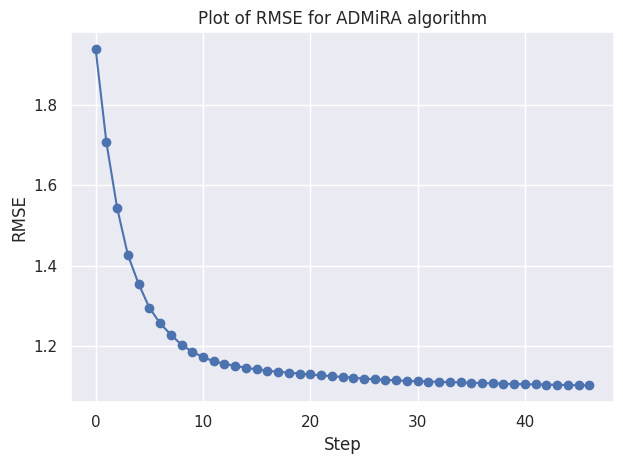

In [ ]:
plt.plot(RMSEs_ADMiRA[1:], marker = 'o');
plt.xlabel('Step')
plt.ylabel('RMSE')
plt.title('Plot of RMSE for ADMiRA algorithm')

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Conclusions

| Algorithm  |  RMSE |Computational time in min | Number of iterations |
| -------- | -------- | -------- | -------- |
| SVP | 1.152 | 19,64 | 42 |
| SVT | 1.625 | 9,95 | 23 |
| ADMiRA | 1.101 | 3,52 | 48 |

> From an analysis of the results of the three algorithms proposed it turns out that:
- In terms of **`RMSE`** **ADMiRA** achieve the best value, even if it's very close to the one obtained by SVP;
- Regarding the **`computational time`** the fastest is again by far the **ADMiRA**;
- Looking at the **`Number of iterations`**, SVT is the one which needs less iterations, almost the double are needed for the SVP and ADMiRA.

Nevertheless, it's crucial to point out that in the **SVT** algorithm for choosing an appropriate lambda we used a function which took more than **1 hour** (increasing the computational time from almost 10 minutes to about 1 hour and 20 minutes), that is a lot! We also noticed that choosing carefully the parameter lambda is not easy, and as it's possible to see from the plots one should find the right trade-off between RMSE and rank minimization. In fact, as the rank of the matrix decreases the RMSE increase.

In the **SVP** algorithm probably the computational time would have been greatly decreased if we had used the function **svds** but as we pointed out before we preferred to create our own thresholding function instead of using one already coded.

In conclusion, the **`best approach`** turns out to be the **ADMiRA** algorithm reaching both the best RMSE and overperforming the other algorithms on computational time (most efficient).

While these algorithms offer powerful tools for low-rank matrix recovery and related problems, one should be aware of their specific **limitations** and considerations when applying them to real-world problems. As an example, ADMiRA and SVP require to specify before the desired rank of the matrix, while SVT offers a way to overcome this problem without specifying it before. But you need to fine-tune the lambda parameter that could be computationally intensive as we saw.

#### 4.1 Curiosity plots

> Let's visualize a piece of the resulted matrices(just a piece because otherwise the figure would be squashed):

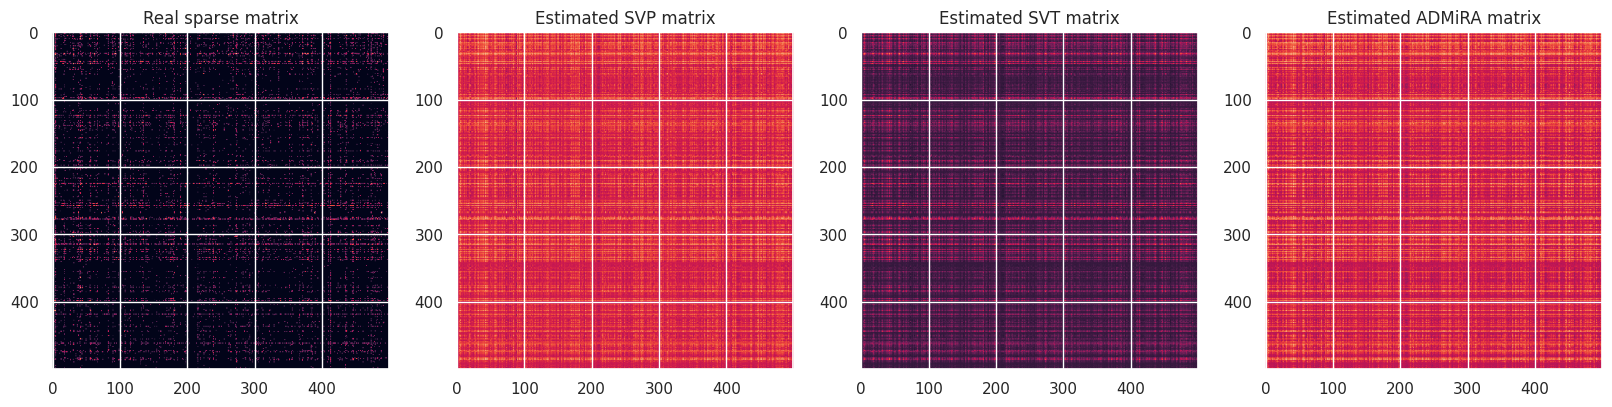

In [ ]:
plt.figure(figsize=(20,40))

plt.subplot(1,4,1)
plt.title('Real sparse matrix')
plt.imshow(sparse_matrix.toarray()[:500,:500])

plt.subplot(1,4,2)
plt.title('Estimated SVP matrix')
plt.imshow(X_SVP[:500,:500]) # abs(X_SVP[:500,:500])

plt.subplot(1,4,3)
plt.title('Estimated SVT matrix')
plt.imshow(X_SVT[:500,:500])

plt.subplot(1,4,4)
plt.title('Estimated ADMiRA matrix')
plt.imshow(X_ADMiRA[:500,:500])

Comparing the rapresentations of a piece of each obtained matrices compared to the real one it's possible to notice how the matrix resulted from SVT is more similar to the original one but with more values slightly different to zero. Instead the SVP one shows a lot of values very far from zero and it's very similar to the ADMiRA one.